<a href="https://colab.research.google.com/github/Praveenprasath04/Documentation_sample/blob/main/orchids_GNT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Getting the necessary codes
!git clone https://github.com/ro-26/orchid_gnt.git

Cloning into 'orchid_gnt'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 35 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 34.73 KiB | 573.00 KiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
# Downloading the model weights
!gdown https://drive.google.com/uc?id=1976YpBEdHpWpcdtAmSzlCfSku91FyX5O

Downloading...
From (original): https://drive.google.com/uc?id=1976YpBEdHpWpcdtAmSzlCfSku91FyX5O
From (redirected): https://drive.google.com/uc?id=1976YpBEdHpWpcdtAmSzlCfSku91FyX5O&confirm=t&uuid=2514004a-c6b1-4025-a792-a61ffa20c29e
To: /content/model_810000.pth
100% 112M/112M [00:01<00:00, 63.3MB/s]


In [1]:
# Downloading the data
!gdown https://drive.google.com/uc?id=1JAnoyDCetmdZuJYTskVNJz3b6oS0be3F

Downloading...
From (original): https://drive.google.com/uc?id=1JAnoyDCetmdZuJYTskVNJz3b6oS0be3F
From (redirected): https://drive.google.com/uc?id=1JAnoyDCetmdZuJYTskVNJz3b6oS0be3F&confirm=t&uuid=8e3605e3-82e1-40de-8463-b73c80da850a
To: /content/orchid.zip
100% 184M/184M [00:05<00:00, 31.9MB/s]


In [ ]:
!mkdir out
!mkdir out/gnt_orchid/
!mv model_810000.pth ./out/gnt_orchid/

In [2]:
!unzip -q orchid.zip

In [4]:
!pip install -q lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.9 MB/s eta 0:00:00


In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import importlib
import torch.utils.data.distributed
import torch.distributed as dist
from torch.utils.data import DataLoader
import imageio
from collections import OrderedDict
from torch.utils.data import Dataset

from orchid_gnt.sample_ray import RaySamplerSingleImage
from orchid_gnt.render_image import render_single_image
from orchid_gnt.projection import Projector
from orchid_gnt.model import GNTModel
from orchid_gnt.llff import *
from orchid_gnt.utils import img_HWC2CHW, colorize

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 163MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

def synchronize():
    """
    Helper function to synchronize (barrier) among all processes when
    using distributed training
    """
    if not dist.is_available():
        return
    if not dist.is_initialized():
        return
    world_size = dist.get_world_size()
    if world_size == 1:
        return
    dist.barrier()


@torch.no_grad()
def eval():
    local_rank = 0
    render_stride = 2

    device = "cuda:{}".format(0)
    out_folder = "./out/gnt_orchid"
    print("outputs will be saved to {}".format(out_folder))
    os.makedirs(out_folder, exist_ok=True)

    dataset = LLFFDataset("validation",scenes="orchids")
    loader = DataLoader(dataset, batch_size=1)
    iterator = iter(loader)

    # Create GNT model
    model = GNTModel()
    # create projector
    projector = Projector(device=device)

    while True:
        try:
            data = next(iterator)
        except:
            break
        if local_rank == 0:
            tmp_ray_sampler = RaySamplerSingleImage(data, device, render_stride=render_stride)
            H, W = tmp_ray_sampler.H, tmp_ray_sampler.W
            torch.cuda.empty_cache()
            model.switch_to_eval()
            with torch.no_grad():
              ray_batch = tmp_ray_sampler.get_all()
              if model.feature_net is not None:
                  featmaps = model.feature_net(ray_batch["src_rgbs"].squeeze(0).permute(0, 3, 1, 2))
              else:
                  featmaps = [None, None]
              ret = render_single_image(
                  ray_sampler=tmp_ray_sampler,
                  ray_batch=ray_batch,
                  model=model,
                  projector=projector,
                  chunk_size=2000,
                  N_samples=64,
                  inv_uniform=True,
                  det=True,
                  N_importance=0,
                  white_bkgd=False,
                  render_stride=render_stride,
                  featmaps=featmaps,
                  ret_alpha=False,
                  single_net=True,
              )
            rgb_coarse = img_HWC2CHW(ret["outputs_coarse"]["rgb"].detach().cpu())

            # if ret["outputs_fine"] is not None:
            #     rgb_fine = img_HWC2CHW(ret["outputs_fine"]["rgb"].detach().cpu())
            # else:
            #     rgb_fine = None

            rgb_coarse = rgb_coarse.permute(1, 2, 0).detach().cpu().numpy()
            plt.imshow(rgb_coarse)
            plt.show()
            # if rgb_fine is not None:
            #     rgb_fine = rgb_fine.permute(1, 2, 0).detach().cpu().numpy()

In [ ]:
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '8001'
torch.cuda.set_device(0)
if not dist.is_initialized():
  torch.distributed.init_process_group(backend="nccl", init_method="env://")
synchronize()

outputs will be saved to ./out/gnt_orchid


/content/orchid_gnt/model.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  to_load = torch.load(filename, map_location="cuda:{}".format(self.local_rank))


Reloading from ./out/gnt_orchid/model_810000.pth, starting at step=810000


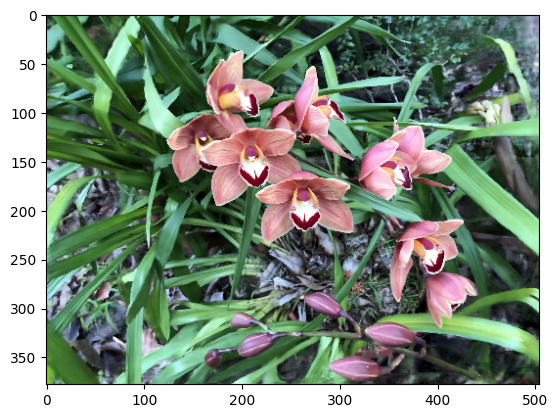

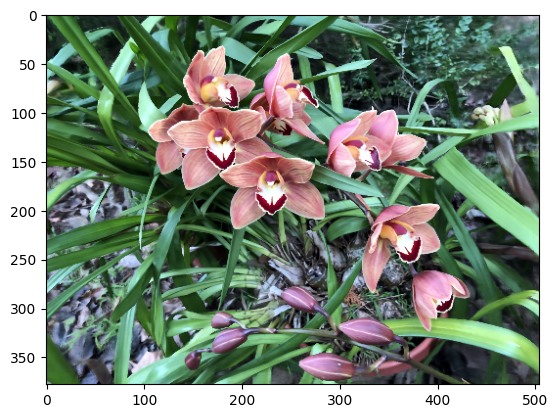

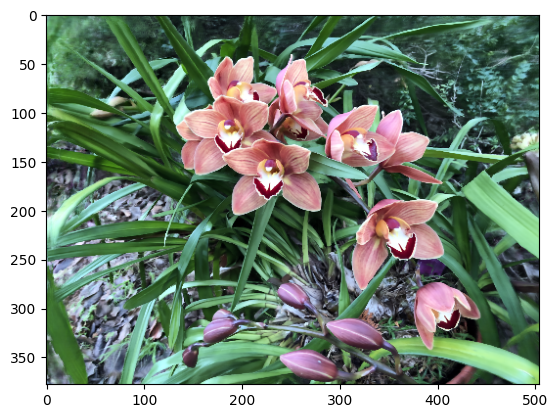

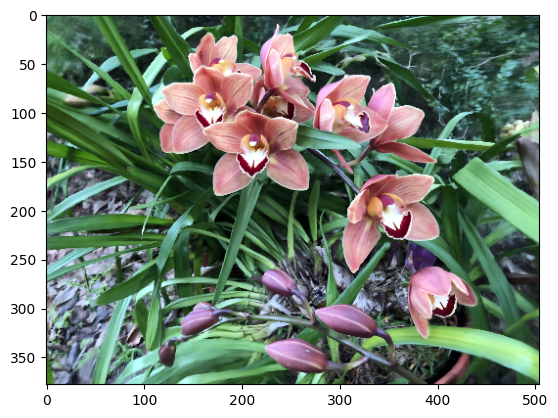

In [ ]:
eval()

In [12]:
dataset = LLFFDataset("validation",scenes="orchids")
loader = DataLoader(dataset, batch_size=1)
iterator = iter(loader)

In [13]:
count = 0
while True:
  try:
    data = next(iterator)
    count += 1
  except:
    break

In [16]:
data['src_rgbs'].shape

torch.Size([1, 10, 756, 1008, 3])